In [ ]:
# Importing the necessary libraries

import pandas as pd

In [ ]:
# Load data
reviews_df = pd.read_csv('imdb_reviews.csv', encoding='utf-8')

In [ ]:
reviews_df

,imdb_id,rating,review_content
0,7026230,10.0,Patton Oswalt has been a long time favorite co...
1,7026230,10.0,"With Patton Oswalt: Annihilation - aka, here's..."
2,7026230,10.0,"Man, that had to have been hard; but he makes ..."
3,7026230,10.0,"Coming off the death of his wife, Patton Oswal..."
4,7026230,5.0,"Patton Oswalt is a funny comedian, for sure.Bu..."
...,...,...,...
84131,421994,6.0,Imagine Me & You is a wryly amusing and well w...
84132,421994,5.0,"The most impressive aspect of this frothy, und..."
84133,421994,9.0,It's so rare to see a film that actually shows...
84134,421994,7.0,Watching this 17 years later in a very differe...


In [ ]:
from langdetect import detect, LangDetectException

# Detect language of the comments and select only the ones in English
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

reviews_df['language'] = reviews_df['review_content'].apply(detect_language)
reviews_df = reviews_df[reviews_df['language'] == 'en']
reviews_df = reviews_df.drop('language', axis=1)

In [129]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(tokens)

# Apply preprocessing to the content column
reviews_df['cleaned_content'] = reviews_df['review_content'].apply(preprocess_text)
reviews_df = reviews_df.drop('review_content', axis=1)

In [130]:
# Count the number of words and characters in each review
reviews_df['word_count'] = reviews_df['cleaned_content'].apply(lambda x: len(x.split()))
reviews_df['char_count'] = reviews_df['cleaned_content'].apply(len)
reviews_df

,imdb_id,rating,cleaned_content,word_count,char_count
0,7026230,10.0,patton oswalt long time favorite comedian mine...,101,689
1,7026230,10.0,patton oswalt annihilation aka life like sure ...,158,999
2,7026230,10.0,man hard make look easy considering level patt...,55,365
3,7026230,10.0,coming death wife patton oswalt delivers great...,74,493
4,7026230,5.0,patton oswalt funny comedian show much focused...,57,373
...,...,...,...,...,...
84131,421994,6.0,imagine wryly amusing well written romantic co...,136,951
84132,421994,5.0,impressive aspect frothy underdeveloped romant...,236,1680
84133,421994,9.0,rare see film actually show people conscience ...,55,350
84134,421994,7.0,watching year later different world made smile...,42,287


In [131]:
# Select the numeric columns
numeric_cols = reviews_df.select_dtypes(include='number')

# Show the correlation matrix
correlation_matrix = numeric_cols.corr()
correlation_matrix

,imdb_id,rating,word_count,char_count
imdb_id,1.000000,-0.089855,-0.176219,-0.171366
rating,-0.089855,1.000000,0.044146,0.050016
word_count,-0.176219,0.044146,1.000000,0.997218
char_count,-0.171366,0.050016,0.997218,1.000000


In [132]:
# Describe the data
reviews_df.describe()

,imdb_id,rating,word_count,char_count
count,8.411900e+04,84119.000000,84119.000000,84119.000000
mean,2.348656e+06,6.474613,129.776281,893.002568
std,1.878193e+06,2.402089,104.692111,734.044235
min,3.542300e+04,1.000000,1.000000,4.000000
25%,8.624670e+05,6.000000,60.000000,404.000000
50%,1.821427e+06,7.000000,95.000000,650.000000
75%,3.458510e+06,8.000000,170.000000,1168.000000
max,8.786466e+06,10.000000,1016.000000,6955.000000


In [134]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment Analysis
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['compound']

reviews_df[['positive', 'negative', 'neutral', 'compound']] = reviews_df['cleaned_content'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [135]:
# Create sentiment labels
def create_sentiment_label(compound_score):
    if compound_score > 0.0:
        return 'positive'
    elif compound_score < 0.0:
        return 'negative'
    else:
        return None

reviews_df['sentiment_label'] = reviews_df['compound'].apply(create_sentiment_label)
sentiment_mapping = {'positive': 1, 'negative': 0}
reviews_df['sentiment_label_encoded'] = reviews_df['sentiment_label'].map(sentiment_mapping)

In [136]:
# Save the data into a new CSV file (for Power BI)
reviews_df.to_csv('imdb_reviews_labeled.csv', index=False)

In [137]:
# Drop rows with 'None' labels (neutral sentiment)
reviews_df = reviews_df.dropna(subset=['sentiment_label'])

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['cleaned_content'])

# Prepare data for Logistic Regression
X = tfidf_features
y = reviews_df['sentiment_label_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [171]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.66      0.77      3389
    Positive       0.92      0.98      0.95     13384

    accuracy                           0.92     16773
   macro avg       0.92      0.82      0.86     16773
weighted avg       0.92      0.92      0.91     16773



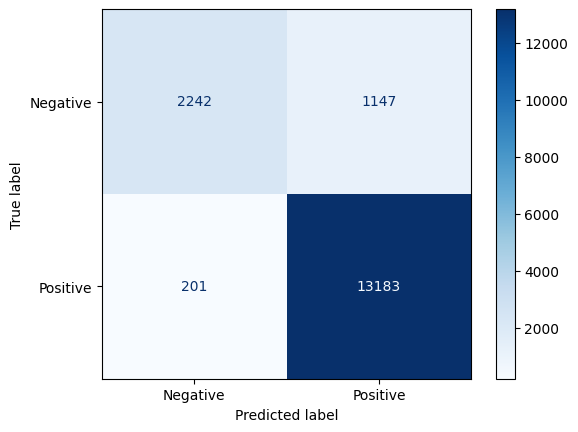

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf= TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(reviews_df['cleaned_content']).toarray()
y=reviews_df['sentiment_label_encoded'].values
print(X)
print(y) 

[[0.         0.         0.         ... 0.         0.         0.13168987]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1. 1. 1. ... 1. 1. 0.]


In [174]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [176]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gnb.fit(X_train,y_train)
y_pred1= gnb.predict(X_test)
print('Accuracy score of Gaussian NB is: ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of Guassian NB is:\n',confusion_matrix(y_test,y_pred1))
print('Precision score of the Gaussian NB is',precision_score(y_test,y_pred1))
print('Recall score of the Gaussian NB is',recall_score(y_test,y_pred1))
print('F1 score of the Gaussian NB is',f1_score(y_test,y_pred1))
print('Classification report of the Gaussian NB is:\n',classification_report(y_test,y_pred1))

Accuracy score of Gaussian NB is:  0.7621176891432659
Confusion Matrix of Guassian NB is:
 [[ 2735   654]
 [ 3336 10048]]
Precision score of the Gaussian NB is 0.9388899271164268
Recall score of the Gaussian NB is 0.7507471607890018
F1 score of the Gaussian NB is 0.8343436020925019
Classification report of the Gaussian NB is:
               precision    recall  f1-score   support

         0.0       0.45      0.81      0.58      3389
         1.0       0.94      0.75      0.83     13384

    accuracy                           0.76     16773
   macro avg       0.69      0.78      0.71     16773
weighted avg       0.84      0.76      0.78     16773



In [177]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of Multinomial NB is:\n',confusion_matrix(y_test,y_pred2))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred2))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred2))
print('F1 score of the Multinomial NB is',f1_score(y_test,y_pred2))
print('Classification report of the Multinomial NB is:\n',classification_report(y_test,y_pred2))

Accuracy score of Multinomial NB is:  0.8248971561438025
Confusion Matrix of Multinomial NB is:
 [[  468  2921]
 [   16 13368]]
Precision score of the Multinomial NB is 0.8206765301737369
Recall score of the Multinomial NB is 0.9988045427375971
F1 score of the Multinomial NB is 0.9010211303204934
Classification report of the Multinomial NB is:
               precision    recall  f1-score   support

         0.0       0.97      0.14      0.24      3389
         1.0       0.82      1.00      0.90     13384

    accuracy                           0.82     16773
   macro avg       0.89      0.57      0.57     16773
weighted avg       0.85      0.82      0.77     16773



In [178]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print('Accuracy score of Bernoulli NB is: ',accuracy_score(y_test,y_pred3))
print('Confusion Matrix of Bernoulli NB is:\n',confusion_matrix(y_test,y_pred3))
print('Precision score of the Bernoulli NB is',precision_score(y_test,y_pred3))
print('Recall score of the Bernoulli NB is',recall_score(y_test,y_pred3))
print('F1 score of the Bernoulli NB is',f1_score(y_test,y_pred3))
print('Classification report of the Bernoulli NB is:\n',classification_report(y_test,y_pred3))

Accuracy score of Bernoulli NB is:  0.8140463840696357
Confusion Matrix of Bernoulli NB is:
 [[ 2722   667]
 [ 2452 10932]]
Precision score of the Bernoulli NB is 0.9424950426760927
Recall score of the Bernoulli NB is 0.8167961745367603
F1 score of the Bernoulli NB is 0.8751551054717208
Classification report of the Bernoulli NB is:
               precision    recall  f1-score   support

         0.0       0.53      0.80      0.64      3389
         1.0       0.94      0.82      0.88     13384

    accuracy                           0.81     16773
   macro avg       0.73      0.81      0.76     16773
weighted avg       0.86      0.81      0.83     16773



In [230]:
# Add a label for the rating (1 for above, 0 for below)
reviews_df['rating_label'] = reviews_df['rating'].apply(lambda x: 1 if x >= 5 else 0)

C:\Users\Victor\AppData\Local\Temp\ipykernel_21840\361767530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['rating_label'] = reviews_df['rating'].apply(lambda x: 1 if x >= 5 else 0)


In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['cleaned_content'])

# Prepare data for Logistic Regression
X = tfidf_features
y = reviews_df['rating_label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [233]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Below', 'Above']))

              precision    recall  f1-score   support

       Below       0.82      0.54      0.65      2980
       Above       0.91      0.97      0.94     13793

    accuracy                           0.90     16773
   macro avg       0.86      0.76      0.80     16773
weighted avg       0.89      0.90      0.89     16773



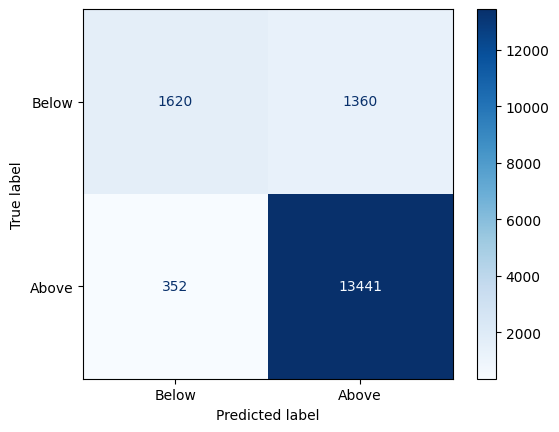

In [234]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below', 'Above'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Importing the necessary libraries

import pandas as pd

In [ ]:
# Load data
reviews_df = pd.read_csv('imdb_reviews.csv', encoding='utf-8')

In [ ]:
reviews_df

,imdb_id,rating,review_content
0,7026230,10.0,Patton Oswalt has been a long time favorite co...
1,7026230,10.0,"With Patton Oswalt: Annihilation - aka, here's..."
2,7026230,10.0,"Man, that had to have been hard; but he makes ..."
3,7026230,10.0,"Coming off the death of his wife, Patton Oswal..."
4,7026230,5.0,"Patton Oswalt is a funny comedian, for sure.Bu..."
...,...,...,...
84131,421994,6.0,Imagine Me & You is a wryly amusing and well w...
84132,421994,5.0,"The most impressive aspect of this frothy, und..."
84133,421994,9.0,It's so rare to see a film that actually shows...
84134,421994,7.0,Watching this 17 years later in a very differe...


In [ ]:
from langdetect import detect, LangDetectException

# Detect language of the comments and select only the ones in English
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

reviews_df['language'] = reviews_df['review_content'].apply(detect_language)
reviews_df = reviews_df[reviews_df['language'] == 'en']
reviews_df = reviews_df.drop('language', axis=1)

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(tokens)

# Apply preprocessing to the content column
reviews_df['cleaned_content'] = reviews_df['review_content'].apply(preprocess_text)
reviews_df = reviews_df.drop('review_content', axis=1)

In [ ]:
# Count the number of words and characters in each review
reviews_df['word_count'] = reviews_df['cleaned_content'].apply(lambda x: len(x.split()))
reviews_df['char_count'] = reviews_df['cleaned_content'].apply(len)
reviews_df

,imdb_id,rating,cleaned_content,word_count,char_count
0,7026230,10.0,patton oswalt long time favorite comedian mine...,101,689
1,7026230,10.0,patton oswalt annihilation aka life like sure ...,158,999
2,7026230,10.0,man hard make look easy considering level patt...,55,365
3,7026230,10.0,coming death wife patton oswalt delivers great...,74,493
4,7026230,5.0,patton oswalt funny comedian show much focused...,57,373
...,...,...,...,...,...
84131,421994,6.0,imagine wryly amusing well written romantic co...,136,951
84132,421994,5.0,impressive aspect frothy underdeveloped romant...,236,1680
84133,421994,9.0,rare see film actually show people conscience ...,55,350
84134,421994,7.0,watching year later different world made smile...,42,287


In [ ]:
# Select the numeric columns
numeric_cols = reviews_df.select_dtypes(include='number')

# Show the correlation matrix
correlation_matrix = numeric_cols.corr()
correlation_matrix

,imdb_id,rating,word_count,char_count
imdb_id,1.000000,-0.089855,-0.176219,-0.171366
rating,-0.089855,1.000000,0.044146,0.050016
word_count,-0.176219,0.044146,1.000000,0.997218
char_count,-0.171366,0.050016,0.997218,1.000000


In [ ]:
# Describe the data
reviews_df.describe()

,imdb_id,rating,word_count,char_count
count,8.411900e+04,84119.000000,84119.000000,84119.000000
mean,2.348656e+06,6.474613,129.776281,893.002568
std,1.878193e+06,2.402089,104.692111,734.044235
min,3.542300e+04,1.000000,1.000000,4.000000
25%,8.624670e+05,6.000000,60.000000,404.000000
50%,1.821427e+06,7.000000,95.000000,650.000000
75%,3.458510e+06,8.000000,170.000000,1168.000000
max,8.786466e+06,10.000000,1016.000000,6955.000000


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment Analysis
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['compound']

reviews_df[['positive', 'negative', 'neutral', 'compound']] = reviews_df['cleaned_content'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [ ]:
# Create sentiment labels
def create_sentiment_label(compound_score):
    if compound_score > 0.0:
        return 'positive'
    elif compound_score < 0.0:
        return 'negative'
    else:
        return None

reviews_df['sentiment_label'] = reviews_df['compound'].apply(create_sentiment_label)
sentiment_mapping = {'positive': 1, 'negative': 0}
reviews_df['sentiment_label_encoded'] = reviews_df['sentiment_label'].map(sentiment_mapping)

In [ ]:
# Save the data into a new CSV file (for Power BI)
reviews_df.to_csv('imdb_reviews_labeled.csv', index=False)

In [ ]:
# Drop rows with 'None' labels (neutral sentiment)
reviews_df = reviews_df.dropna(subset=['sentiment_label'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['cleaned_content'])

# Prepare data for Logistic Regression
X = tfidf_features
y = reviews_df['sentiment_label_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.66      0.77      3389
    Positive       0.92      0.98      0.95     13384

    accuracy                           0.92     16773
   macro avg       0.92      0.82      0.86     16773
weighted avg       0.92      0.92      0.91     16773



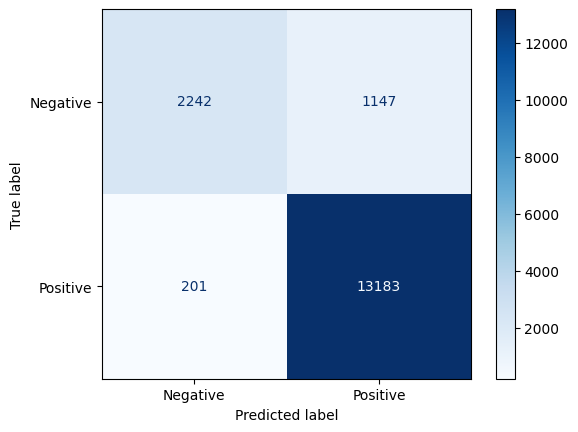

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf= TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(reviews_df['cleaned_content']).toarray()
y=reviews_df['sentiment_label_encoded'].values
print(X)
print(y) 

[[0.         0.         0.         ... 0.         0.         0.13168987]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1. 1. 1. ... 1. 1. 0.]


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gnb.fit(X_train,y_train)
y_pred1= gnb.predict(X_test)
print('Accuracy score of Gaussian NB is: ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of Guassian NB is:\n',confusion_matrix(y_test,y_pred1))
print('Precision score of the Gaussian NB is',precision_score(y_test,y_pred1))
print('Recall score of the Gaussian NB is',recall_score(y_test,y_pred1))
print('F1 score of the Gaussian NB is',f1_score(y_test,y_pred1))
print('Classification report of the Gaussian NB is:\n',classification_report(y_test,y_pred1))

Accuracy score of Gaussian NB is:  0.7621176891432659
Confusion Matrix of Guassian NB is:
 [[ 2735   654]
 [ 3336 10048]]
Precision score of the Gaussian NB is 0.9388899271164268
Recall score of the Gaussian NB is 0.7507471607890018
F1 score of the Gaussian NB is 0.8343436020925019
Classification report of the Gaussian NB is:
               precision    recall  f1-score   support

         0.0       0.45      0.81      0.58      3389
         1.0       0.94      0.75      0.83     13384

    accuracy                           0.76     16773
   macro avg       0.69      0.78      0.71     16773
weighted avg       0.84      0.76      0.78     16773



In [ ]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of Multinomial NB is:\n',confusion_matrix(y_test,y_pred2))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred2))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred2))
print('F1 score of the Multinomial NB is',f1_score(y_test,y_pred2))
print('Classification report of the Multinomial NB is:\n',classification_report(y_test,y_pred2))

Accuracy score of Multinomial NB is:  0.8248971561438025
Confusion Matrix of Multinomial NB is:
 [[  468  2921]
 [   16 13368]]
Precision score of the Multinomial NB is 0.8206765301737369
Recall score of the Multinomial NB is 0.9988045427375971
F1 score of the Multinomial NB is 0.9010211303204934
Classification report of the Multinomial NB is:
               precision    recall  f1-score   support

         0.0       0.97      0.14      0.24      3389
         1.0       0.82      1.00      0.90     13384

    accuracy                           0.82     16773
   macro avg       0.89      0.57      0.57     16773
weighted avg       0.85      0.82      0.77     16773



In [ ]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print('Accuracy score of Bernoulli NB is: ',accuracy_score(y_test,y_pred3))
print('Confusion Matrix of Bernoulli NB is:\n',confusion_matrix(y_test,y_pred3))
print('Precision score of the Bernoulli NB is',precision_score(y_test,y_pred3))
print('Recall score of the Bernoulli NB is',recall_score(y_test,y_pred3))
print('F1 score of the Bernoulli NB is',f1_score(y_test,y_pred3))
print('Classification report of the Bernoulli NB is:\n',classification_report(y_test,y_pred3))

Accuracy score of Bernoulli NB is:  0.8140463840696357
Confusion Matrix of Bernoulli NB is:
 [[ 2722   667]
 [ 2452 10932]]
Precision score of the Bernoulli NB is 0.9424950426760927
Recall score of the Bernoulli NB is 0.8167961745367603
F1 score of the Bernoulli NB is 0.8751551054717208
Classification report of the Bernoulli NB is:
               precision    recall  f1-score   support

         0.0       0.53      0.80      0.64      3389
         1.0       0.94      0.82      0.88     13384

    accuracy                           0.81     16773
   macro avg       0.73      0.81      0.76     16773
weighted avg       0.86      0.81      0.83     16773



In [ ]:
# Add a label for the rating (1 for above, 0 for below)
reviews_df['rating_label'] = reviews_df['rating'].apply(lambda x: 1 if x >= 5 else 0)

C:\Users\Victor\AppData\Local\Temp\ipykernel_21840\361767530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['rating_label'] = reviews_df['rating'].apply(lambda x: 1 if x >= 5 else 0)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Feature Extraction
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['cleaned_content'])

# Prepare data for Logistic Regression
X = tfidf_features
y = reviews_df['rating_label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Below', 'Above']))

              precision    recall  f1-score   support

       Below       0.82      0.54      0.65      2980
       Above       0.91      0.97      0.94     13793

    accuracy                           0.90     16773
   macro avg       0.86      0.76      0.80     16773
weighted avg       0.89      0.90      0.89     16773



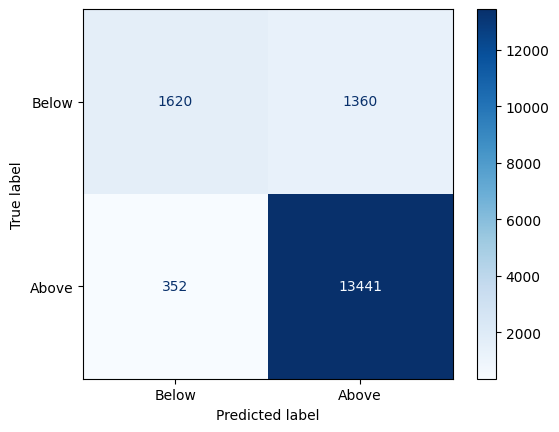

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below', 'Above'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf= TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(reviews_df['cleaned_content']).toarray()
y=reviews_df['rating_label'].values
print(X)
print(y) 

[[0.         0.         0.         ... 0.         0.         0.13168987]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1 1 1 ... 1 1 0]


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [ ]:
gnb.fit(X_train,y_train)
y_pred1= gnb.predict(X_test)
print('Accuracy score of Gaussian NB is: ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of Guassian NB is:\n',confusion_matrix(y_test,y_pred1))
print('Precision score of the Gaussian NB is',precision_score(y_test,y_pred1))
print('Recall score of the Gaussian NB is',recall_score(y_test,y_pred1))
print('F1 score of the Gaussian NB is',f1_score(y_test,y_pred1))
print('Classification report of the Gaussian NB is:\n',classification_report(y_test,y_pred1))

Accuracy score of Gaussian NB is:  0.7612233947415489
Confusion Matrix of Guassian NB is:
 [[ 2264   716]
 [ 3289 10504]]
Precision score of the Gaussian NB is 0.9361853832442067
Recall score of the Gaussian NB is 0.7615457115928369
F1 score of the Gaussian NB is 0.8398832607044336
Classification report of the Gaussian NB is:
               precision    recall  f1-score   support

           0       0.41      0.76      0.53      2980
           1       0.94      0.76      0.84     13793

    accuracy                           0.76     16773
   macro avg       0.67      0.76      0.69     16773
weighted avg       0.84      0.76      0.78     16773



In [ ]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of Multinomial NB is:\n',confusion_matrix(y_test,y_pred2))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred2))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred2))
print('F1 score of the Multinomial NB is',f1_score(y_test,y_pred2))
print('Classification report of the Multinomial NB is:\n',classification_report(y_test,y_pred2))

Accuracy score of Multinomial NB is:  0.8496393012579742
Confusion Matrix of Multinomial NB is:
 [[  486  2494]
 [   28 13765]]
Precision score of the Multinomial NB is 0.8466080324743219
Recall score of the Multinomial NB is 0.9979699847748859
F1 score of the Multinomial NB is 0.916078796752296
Classification report of the Multinomial NB is:
               precision    recall  f1-score   support

           0       0.95      0.16      0.28      2980
           1       0.85      1.00      0.92     13793

    accuracy                           0.85     16773
   macro avg       0.90      0.58      0.60     16773
weighted avg       0.86      0.85      0.80     16773



In [ ]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print('Accuracy score of Bernoulli NB is: ',accuracy_score(y_test,y_pred3))
print('Confusion Matrix of Bernoulli NB is:\n',confusion_matrix(y_test,y_pred3))
print('Precision score of the Bernoulli NB is',precision_score(y_test,y_pred3))
print('Recall score of the Bernoulli NB is',recall_score(y_test,y_pred3))
print('F1 score of the Bernoulli NB is',f1_score(y_test,y_pred3))
print('Classification report of the Bernoulli NB is:\n',classification_report(y_test,y_pred3))

Accuracy score of Bernoulli NB is:  0.717104870923508
Confusion Matrix of Bernoulli NB is:
 [[2350  630]
 [4115 9678]]
Precision score of the Bernoulli NB is 0.9388824214202561
Recall score of the Bernoulli NB is 0.7016602624519684
F1 score of the Bernoulli NB is 0.8031202024812248
Classification report of the Bernoulli NB is:
               precision    recall  f1-score   support

           0       0.36      0.79      0.50      2980
           1       0.94      0.70      0.80     13793

    accuracy                           0.72     16773
   macro avg       0.65      0.75      0.65     16773
weighted avg       0.84      0.72      0.75     16773



In [235]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf= TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(reviews_df['cleaned_content']).toarray()
y=reviews_df['rating_label'].values
print(X)
print(y) 

[[0.         0.         0.         ... 0.         0.         0.13168987]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1 1 1 ... 1 1 0]


In [236]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [237]:
gnb.fit(X_train,y_train)
y_pred1= gnb.predict(X_test)
print('Accuracy score of Gaussian NB is: ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of Guassian NB is:\n',confusion_matrix(y_test,y_pred1))
print('Precision score of the Gaussian NB is',precision_score(y_test,y_pred1))
print('Recall score of the Gaussian NB is',recall_score(y_test,y_pred1))
print('F1 score of the Gaussian NB is',f1_score(y_test,y_pred1))
print('Classification report of the Gaussian NB is:\n',classification_report(y_test,y_pred1))

Accuracy score of Gaussian NB is:  0.7612233947415489
Confusion Matrix of Guassian NB is:
 [[ 2264   716]
 [ 3289 10504]]
Precision score of the Gaussian NB is 0.9361853832442067
Recall score of the Gaussian NB is 0.7615457115928369
F1 score of the Gaussian NB is 0.8398832607044336
Classification report of the Gaussian NB is:
               precision    recall  f1-score   support

           0       0.41      0.76      0.53      2980
           1       0.94      0.76      0.84     13793

    accuracy                           0.76     16773
   macro avg       0.67      0.76      0.69     16773
weighted avg       0.84      0.76      0.78     16773



In [238]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of Multinomial NB is:\n',confusion_matrix(y_test,y_pred2))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred2))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred2))
print('F1 score of the Multinomial NB is',f1_score(y_test,y_pred2))
print('Classification report of the Multinomial NB is:\n',classification_report(y_test,y_pred2))

Accuracy score of Multinomial NB is:  0.8496393012579742
Confusion Matrix of Multinomial NB is:
 [[  486  2494]
 [   28 13765]]
Precision score of the Multinomial NB is 0.8466080324743219
Recall score of the Multinomial NB is 0.9979699847748859
F1 score of the Multinomial NB is 0.916078796752296
Classification report of the Multinomial NB is:
               precision    recall  f1-score   support

           0       0.95      0.16      0.28      2980
           1       0.85      1.00      0.92     13793

    accuracy                           0.85     16773
   macro avg       0.90      0.58      0.60     16773
weighted avg       0.86      0.85      0.80     16773



In [239]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print('Accuracy score of Bernoulli NB is: ',accuracy_score(y_test,y_pred3))
print('Confusion Matrix of Bernoulli NB is:\n',confusion_matrix(y_test,y_pred3))
print('Precision score of the Bernoulli NB is',precision_score(y_test,y_pred3))
print('Recall score of the Bernoulli NB is',recall_score(y_test,y_pred3))
print('F1 score of the Bernoulli NB is',f1_score(y_test,y_pred3))
print('Classification report of the Bernoulli NB is:\n',classification_report(y_test,y_pred3))

Accuracy score of Bernoulli NB is:  0.717104870923508
Confusion Matrix of Bernoulli NB is:
 [[2350  630]
 [4115 9678]]
Precision score of the Bernoulli NB is 0.9388824214202561
Recall score of the Bernoulli NB is 0.7016602624519684
F1 score of the Bernoulli NB is 0.8031202024812248
Classification report of the Bernoulli NB is:
               precision    recall  f1-score   support

           0       0.36      0.79      0.50      2980
           1       0.94      0.70      0.80     13793

    accuracy                           0.72     16773
   macro avg       0.65      0.75      0.65     16773
weighted avg       0.84      0.72      0.75     16773

